# Building Production Machine Learning Systems


This notebook creates a [SageMaker Pipeline](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html) to build an end-to-end Machine Learning system to solve the problem of classifying penguin species. With a SageMaker Pipeline, you can create, automate, and manage end-to-end Machine Learning workflows at scale.

You can find more information about Amazon SageMaker in the [Amazon SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html). The [AWS Machine Learning Blog](https://aws.amazon.com/blogs/machine-learning/) is an excellent source to stay up-to-date with SageMaker.

This example uses the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data), the [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html) library, and the [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/).

<img src='images/penguins.png' alt='Penguins' width="800">

This notebook is part of the [Machine Learning School](https://www.ml.school) program.


## Initial setup

:::{.callout-note}
Before running this notebook, follow the [Setup Instructions](https://program.ml.school/setup.html) for the program.
:::

Let's start by setting up the environment and preparing to run the notebook.

In [1]:
#| hide

%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import sys
import logging
import ipytest
import json
from pathlib import Path


CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(parents=True, exist_ok=True)
INFERENCE_CODE_FOLDER = CODE_FOLDER / "inference"
INFERENCE_CODE_FOLDER.mkdir(parents=True, exist_ok=True)

sys.path.extend([f"./{CODE_FOLDER}", f"./{INFERENCE_CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

We can run this notebook in [Local Mode](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-local-mode.html) to test the pipeline in your local environment before using SageMaker. You can run the code in Local Mode by setting the LOCAL_MODE constant to True

In [2]:
LOCAL_MODE = False

Let's load the S3 bucket name and the AWS Role from the environment variables:

In [3]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

S3_LOCATION = f"s3://{bucket}/penguins"

If you are running the pipeline in Local Mode on an ARM64 machine, you will need to use a custom Docker image to train and evaluate the model. This is because SageMaker doesn't provide a TensorFlow image that supports Apple's M chips.

In [4]:
architecture = !(uname -m)
IS_APPLE_M_CHIP = architecture[0] == "arm64"

Let's create a configuration dictionary with different settings depending on whether we are running the pipeline in Local Mode or not:

In [5]:
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession, LocalPipelineSession

pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": "sagemaker-tensorflow-toolkit-local" if IS_APPLE_M_CHIP else None,
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

config["framework_version"] = "2.11"
config["py_version"] = "py39"

Let's now initialize a few variables that we'll need throughout the notebook:

In [6]:
import boto3

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

### Step 1 - Exploratory Data Analysis

Let's run Exploratory Data Analysis on the dataset. The goal of this section is to understand the data and the problem we are trying to solve.

Let's load the Penguins dataset:

In [7]:
import pandas as pd
import numpy as np

penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


We can see the dataset contains the following columns:

1. `species`: The species of a penguin. This is the column we want to predict.
2. `island`: The island where the penguin was found
3. `culmen_length_mm`: The length of the penguin's culmen (bill) in millimeters
4. `culmen_depth_mm`: The depth of the penguin's culmen in millimeters
5. `flipper_length_mm`: The length of the penguin's flipper in millimeters
6. `body_mass_g`: The body mass of the penguin in grams
7. `sex`: The sex of the penguin

If you are curious, here is the description of a penguin's culmen:

<img src='images/culmen.jpeg' alt='Culmen' width="600">

Now, let's get the summary statistics for the features in our dataset.

In [8]:
penguins.describe(include='all')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


Let's now display the distribution of values for the three categorical columns in our data:


In [9]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution)
print()
print(island_distribution)
print()
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


The distribution of the categories in our data are:

-   `species`: There are 3 species of penguins in the dataset: Adelie (152), Gentoo (124), and Chinstrap (68).
-   `island`: Penguins are from 3 islands: Biscoe (168), Dream (124), and Torgersen (52).
-   `sex`: We have 168 male penguins, 165 female penguins, and 1 penguin with an ambiguous gender (`.`).

Let's replace the ambiguous value in the `sex` column with a null value:

In [10]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)

sex_distribution = penguins["sex"].value_counts()
print(sex_distribution)

sex
MALE      168
FEMALE    165
Name: count, dtype: int64


Now, let's check the missing value in the data

In [11]:
penguins.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's get rid of the missing values. For now, we are going to replace the missing values with the most frequent value in the column. Later, we'll use a different strategy to replace missing numeric values.


In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
penguins.iloc[:, :] = imputer.fit_transform(penguins)
penguins.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Let's visualize the distribution of categorical features.


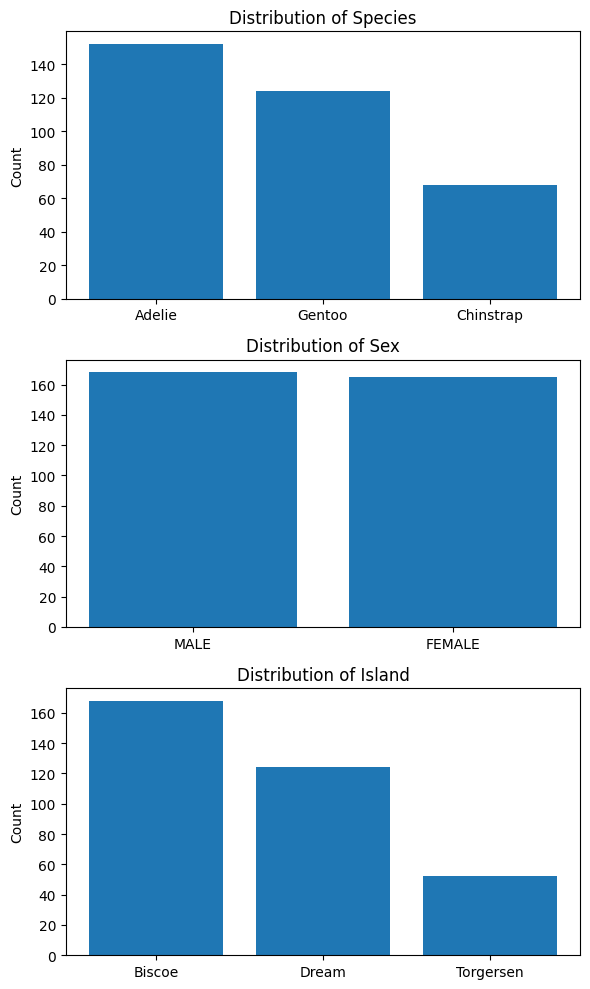

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(6,10))

ax[0].bar(species_distribution.index, species_distribution.values)
ax[0].set_ylabel("Count")
ax[0].set_title("Distribution of Species")

ax[1].bar(sex_distribution.index, sex_distribution.values)
ax[1].set_ylabel("Count")
ax[1].set_title("Distribution of Sex")

ax[2].bar(island_distribution.index, island_distribution.values)
ax[2].set_ylabel("Count")
ax[2].set_title("Distribution of Island")

plt.tight_layout()
plt.show()

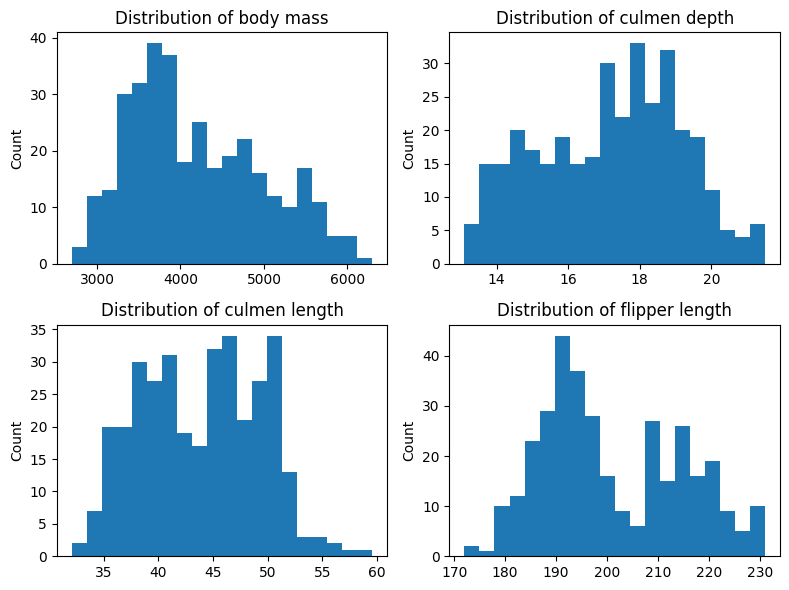

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))

axs[0, 0].hist(penguins["body_mass_g"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of body mass")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen depth")

axs[1, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of culmen length")

axs[1, 1].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of flipper length")

plt.tight_layout()
plt.show()

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

In [15]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Here are three examples of what we get from interpreting the covariance matrix below:

1. Penguins that weight more tend to have a larger culmen.
2. The more a penguin weights, the shallower its culmen tends to be.
3. There's a small variance between the culmen depth of penguins.

Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables.

In [16]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have larger flippers.
2. Penguins with a shallower culmen tend to have larger flippers.
3. The length and depth of the culmen have a slight negative correlation.

Let's display the distribution of species by island.

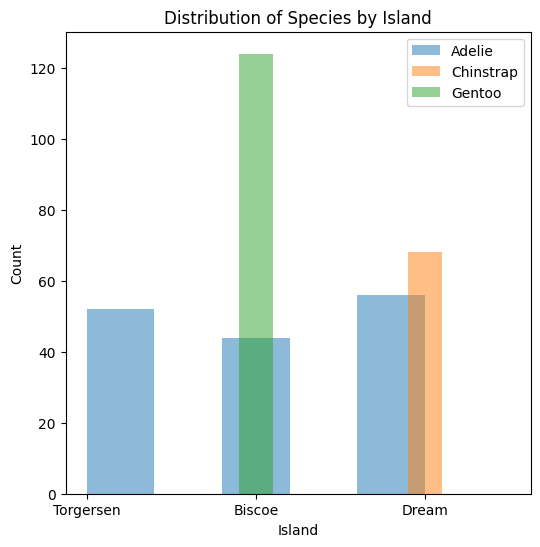

In [17]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], alpha=0.5, bins=5, label=species)

ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Island")
ax.legend()
plt.show()

Let's display the distribution of species by sex.


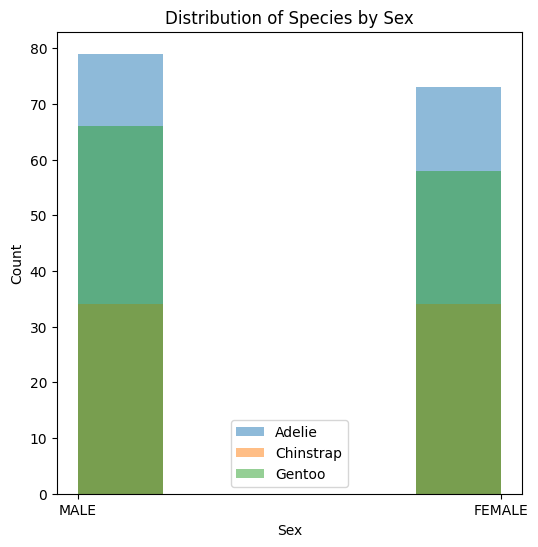

In [18]:
fig, ax = plt.subplots(figsize=(6,6))

for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["sex"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Sex")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Sex")
ax.legend()
plt.show()

### Step 2 - Creating the Preprocessing Script

Here's a high-level overview of the preprocessing step and the Processing Job that SageMaker creates behind the scenes:

<a href="images/preprocess-data.png" target="_blank"> <img src="images/preprocess-data.png" alt="High-level overview of the Preprocessing Data Step and SageMaker’s Processing Jobs" style="max-width: 750px;" /></a>

The first step we need in the pipeline is a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to run a script that will split and transform the data. This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) SageMaker's SDK documentation for more information.


The first step is to create the script that will split and transform the input data.

In [36]:
%%writefile {CODE_FOLDER}/preprocessor.py
#| label: preprocessing-script
#| echo: true
#| output: false
#| filename: preprocessor.py
#| code-line-numbers: true

import os
import tarfile
import tempfile
import joblib
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder


def preprocess(base_directory):
    """
    This function loads the supplied data, splits it and transforms it.
    """

    df = _read_data_from_input_csv_files(base_directory)
    
    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])]
    )
    
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler()
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder()
    )
    
    features_transformer = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, make_column_selector(dtype_exclude="object")),
            ("categorical", categorical_transformer, ["island"]),
        ]
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_baselines(base_directory, df_train, df_test)

    y_train = target_transformer.fit_transform(np.array(df_train.species.values).reshape(-1, 1))
    y_validation = target_transformer.transform(np.array(df_validation.species.values).reshape(-1, 1))
    y_test = target_transformer.transform(np.array(df_test.species.values).reshape(-1, 1))
    
    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)
    X_validation = features_transformer.transform(df_validation)
    X_test = features_transformer.transform(df_test)

    _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test)
    _save_model(base_directory, target_transformer, features_transformer)
    

def _read_data_from_input_csv_files(base_directory):
    """
    This function reads every CSV file available and concatenates
    them into a single dataframe.
    """

    input_directory = Path(base_directory) / "input"
    files = [file for file in input_directory.glob("*.csv")]
    
    if len(files) == 0:
        raise ValueError(f"The are no CSV files in {str(input_directory)}/")
        
    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)
    
    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """
    Splits the data into three sets: train, validation and test.
    """

    #df_train, temp = train_test_split(df, test_size=0.3, stratify=df["species"])
    #df_validation, df_test = train_test_split(temp, test_size=0.5, stratify=temp["species"])

    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_baselines(base_directory, df_train, df_test):
    """
    During the data and quality monitoring steps, we will need baselines
    to compute constraints and statistics. This function saves the 
    untransformed data to disk so we can use them as baselines later.
    """

    for split, data in [("train", df_train), ("test", df_test)]:
        baseline_path = Path(base_directory) / f"{split}-baseline"
        baseline_path.mkdir(parents=True, exist_ok=True)

        df = data.copy().dropna()

        # We want to save the header only for the train baseline
        # but not for the test baseline. We'll use the test baseline
        # to generate predictions later, and we can't have a header line
        # because the model won't be able to make a prediction for it.
        header = split == "train"
        df.to_csv(baseline_path / f"{split}-baseline.csv", header=header, index=False)


def _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test):
    """
    This function concatenates the transformed features and the target variable, and
    saves each one of the split sets to disk.
    """

    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(validation_path / "validation.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """
    This function creates a model.tar.gz file that contains the two transformation
    pipelines we built to transform the data.
    """

    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, os.path.join(directory, "target.joblib"))
        joblib.dump(features_transformer, os.path.join(directory, "features.joblib"))
    
        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)
    
        with tarfile.open(f"{str(model_path / 'model.tar.gz')}", "w:gz") as tar:
            tar.add(os.path.join(directory, "target.joblib"), arcname="target.joblib")
            tar.add(os.path.join(directory, "features.joblib"), arcname="features.joblib")

    
if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/preprocessor.py


Let's test the script to ensure everything is working as expected:

In [37]:
%%ipytest -s
#| code-fold: true
#| output: false

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib
from preprocessor import preprocess


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    preprocess(base_directory=directory)
    
    yield directory
    
    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)
    
    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 7

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv", header=None)

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv", header=None)

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "species"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "species"

........
8 passed in 0.20s


### Step 3 - Setting up the Processing Step

Let's now define the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that we'll use in the pipeline to run the script that will split and transform the data.

Several SageMaker Pipeline steps support caching. When a step runs, and dependending on the configured caching policy, SageMaker will try to reuse the result of a previous successful run of the same step. You can find more information about this topic in [Caching Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html). Let's define a caching policy that we'll reuse on every step:


In [38]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

We can parameterize a SageMaker Pipeline to make it more flexible. In this case, we'll use a parameter to pass the location of the dataset we want to process. We can execute the pipeline with different datasets by changing the value of this parameter. To read more about these parameters, check [Pipeline Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html).

In [39]:
from sagemaker.workflow.parameters import ParameterString

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch the Processing Job. To run the script we created, we need access to Scikit-Learn, so we can use the [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) processor that comes out-of-the-box with the SageMaker's Python SDK. 

SageMaker manages the infrastructure of a Processing Job. It provisions resources for the duration of the job, and cleans up when it completes. The Processing Container image that SageMaker uses to run a Processing Job can either be a SageMaker built-in image or a custom image.

The [Data Processing with Framework Processors](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) page discusses other built-in processors you can use. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region.

In [40]:
#| code: true
#| output: false
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

Let's now define the Processing Step that we'll use in the pipeline. This step requires a list of inputs that we need on the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [41]:
# | code: true
# | output: false

from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingInput, ProcessingOutput


preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{CODE_FOLDER}/preprocessor.py",
        inputs=[
            ProcessingInput(
                source=dataset_location, destination="/opt/ml/processing/input"
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

/Users/monusingh/work-share/books-courses-moocs/adiy-book-courses-moocs/ml-school/.venv/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Step 4 - Creating the Pipeline

We can now create the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [42]:
# | code: true
# | output: false

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

session1_pipeline = Pipeline(
    name="session1-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session1_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:211973426211:pipeline/session1-pipeline',
 'ResponseMetadata': {'RequestId': '3e1e23ab-da80-436f-a3dc-bac0bd30f087',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3e1e23ab-da80-436f-a3dc-bac0bd30f087',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Mon, 15 Jan 2024 09:20:25 GMT'},
  'RetryAttempts': 0}}

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [43]:
#%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

session1_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:211973426211:pipeline/session1-pipeline/execution/4qwn7aweywqb', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x110c02010>)

 <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.2</strong></span> The pipeline uses Random Sampling to split the dataset. Modify the code to use Stratified Sampling instead. The goal of this assignment is to help you familiarize with how to modify the preprocessing script and re-run the pipeline to see your changes in action.
 

In [ ]:
from sklearn.model_selection import train_test_split

def _split_data(df):
    """
    Splits the data into three sets: train, validation and test.
    """

    df_train, temp = train_test_split(df, test_size=0.3, stratify=df["species"])
    df_validation, df_test = train_test_split(temp, test_size=0.5, stratify=temp["species"])

    #df_train, temp = train_test_split(df, test_size=0.3)
    #df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test

<span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.3</strong></span> We can specify different parameter values in a pipeline at the time we start it. In this session, we defined a `dataset_location` parameter that specifies the location of the data that we want the pipeline to process. For this assignment, use ChatGPT to generate dataset with 500 random penguins and store the file in S3. Then, run the pipeline pointing the `dataset_location` to the new dataset. Here is an explanation of how to [override default parameters during a pipeline execution](https://docs.aws.amazon.com/sagemaker/latest/dg/run-pipeline.html#run-pipeline-parametrized). You can use the Advanced Data Analysis tool from ChatGPT to generate the fake data. If you don't have access to it, you can simply duplicate your dataset and store it at a different S3 location.


In [50]:
S3_LOCATION = f"s3://{bucket}/penguins-new"

execution = session1_pipeline.start(
    parameters=dict(
        dataset_location=f"{S3_LOCATION}/data",
    )
)
execution.list_steps()

[]